In [1]:
%pip install wandb huggingface_hub transformers datasets accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 140.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 37.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [1]:
from huggingface_hub import notebook_login
import os
import wandb

wandb.login()
notebook_login()

wandb: Currently logged in as: kevinv3796. Use `wandb login --relogin` to force relogin


In [2]:
import torch

context_length = 256
torch.manual_seed(42)

In [3]:
from datasets import load_dataset

raw_dataset = load_dataset("ArtifactAI/arxiv_python_research_code")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['repo', 'file', 'code', 'file_length', 'avg_line_length', 'max_line_length', 'extension_type'],
        num_rows: 1415924
    })
})

In [5]:
print(raw_dataset["train"][123456]["code"])

"""Routines to help recognizing sound files.

Function whathdr() recognizes various types of sound file headers.
It understands almost all headers that SOX can decode.

The return tuple contains the following items, in this order:
- file type (as SOX understands it)
- sampling rate (0 if unknown or hard to decode)
- number of channels (0 if unknown or hard to decode)
- number of frames in the file (-1 if unknown or hard to decode)
- number of bits/sample, or 'U' for U-LAW, or 'A' for A-LAW

If the file doesn't have a recognizable type, it returns None.
If the file can't be opened, IOError is raised.

To compute the total time, divide the number of frames by the
sampling rate (a frame contains a sample for each channel).

Function what() calls whathdr().  (It used to also use some
heuristics for raw data, but this doesn't work very well.)

Finally, the function test() is a simple main program that calls
what() for all files mentioned on the argument list.  For directory
arguments it cal

In [7]:
from datasets import load_dataset, DatasetDict

ds_train = raw_dataset["train"]

raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(50000)),
        "valid": ds_train.shuffle().select(range(500))
    }
)

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

In [17]:
outputs = tokenizer(
    raw_datasets["train"][:5]["code"],
    truncation = True,
    max_length = context_length,
    return_overflowing_tokens = True,
    return_length = True
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 37
Input chunk lengths: [145, 0, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 42, 256, 256, 256, 256, 234, 256, 256, 256, 256, 11]
Chunk mapping: [0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]


In [20]:
def tokenize(element):
    outputs = tokenizer(
    element["code"],
    truncation = True,
    max_length = context_length,
    return_overflowing_tokens = True,
    return_length = True
)
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)

    return {
        "input_ids": input_batch
    }


tokenized_datasets = raw_datasets.map(
    tokenize, batched = True, remove_columns = raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 464842
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 3823
    })
})

## Model

In [22]:
import os
os.environ["WANDB_PROJECT"] = "python-gpt2"

In [23]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size = len(tokenizer),
    n_ctx = context_length,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id
)

model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT2 size: {model_size/1000**2:.1f}M parameters")

GPT2 size: 124.2M parameters


In [21]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm = False)

In [25]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir = "python-gpt2",
    per_device_train_batch_size= 32,
    per_device_eval_batch_size = 32,
    evaluation_strategy="steps",
    eval_steps=25,
    logging_steps=25,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps = 50,
    fp16 = True,
    report_to="wandb"
)

trainer = Trainer(
    model = model,
    tokenizer=tokenizer,
    args = args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"]
)

In [26]:
trainer.train()

Step,Training Loss,Validation Loss
25,9.295600,7.948318
50,6.831900,6.046336
75,5.653000,5.390481
100,5.099800,5.052270
125,4.729600,4.729485
150,4.467600,4.480144
175,4.228500,4.258027
200,4.033500,4.089088
225,3.865400,3.937627
250,3.744200,3.822187


TrainOutput(global_step=1815, training_loss=2.709979592735774, metrics={'train_runtime': 5312.5845, 'train_samples_per_second': 87.498, 'train_steps_per_second': 0.342, 'total_flos': 6.070336487424e+16, 'train_loss': 2.709979592735774, 'epoch': 0.9995181386383974})

In [27]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/497M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/MadMarx37/python-gpt2/commit/7ef7c5a548a13f4380ab38e563cf511b1b3151f9', commit_message='End of training', commit_description='', oid='7ef7c5a548a13f4380ab38e563cf511b1b3151f9', pr_url=None, pr_revision=None, pr_num=None)

In [28]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model = "MadMarx37/python-gpt2", device = device
)

config.json:   0%|          | 0.00/898 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/497M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/789k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/448k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

In [35]:
wandb.run.finish()

eval/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▁▂▂▂▂▂▁▁▁▁▂▂▂▁▂▂▅▅▄▇▃▂▃▁▂▃▂▁▁▂▂▂▁▃▄▂█▁
eval/samples_per_second,█▇█▇▇▇▇▇████▇▇▇█▇▇▄▄▅▂▆▇▆█▇▆▇██▇▇▇█▆▅▇▁█
eval/steps_per_second,█▇█▇▇▇▇▇█▇██▇▇▇█▇▇▄▄▅▂▆▇▅█▇▆▇██▇▇▇█▆▅▇▁█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▃▄███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,2.14483
eval/runtime,13.3823


## Evaluate pretrained GPT2

In [30]:
def generate_output(prompt):
    return pipe(txt, num_return_sequences=1)[0]["generated_text"]

In [31]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(generate_output(txt))

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
data = np.random.randn(100)

#


In [32]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(generate_output(txt))

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
def make_df(df):
    df.to_csv(


In [33]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(generate_output(txt))

# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
df.values.columns


In [34]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(generate_output(txt))


# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
# 0 = random.randint(1, 100)
# 2 =


As we can see, the outputs here are not great - which is to be expected, considering our model is only 125M params, plus our training was quite limited. 

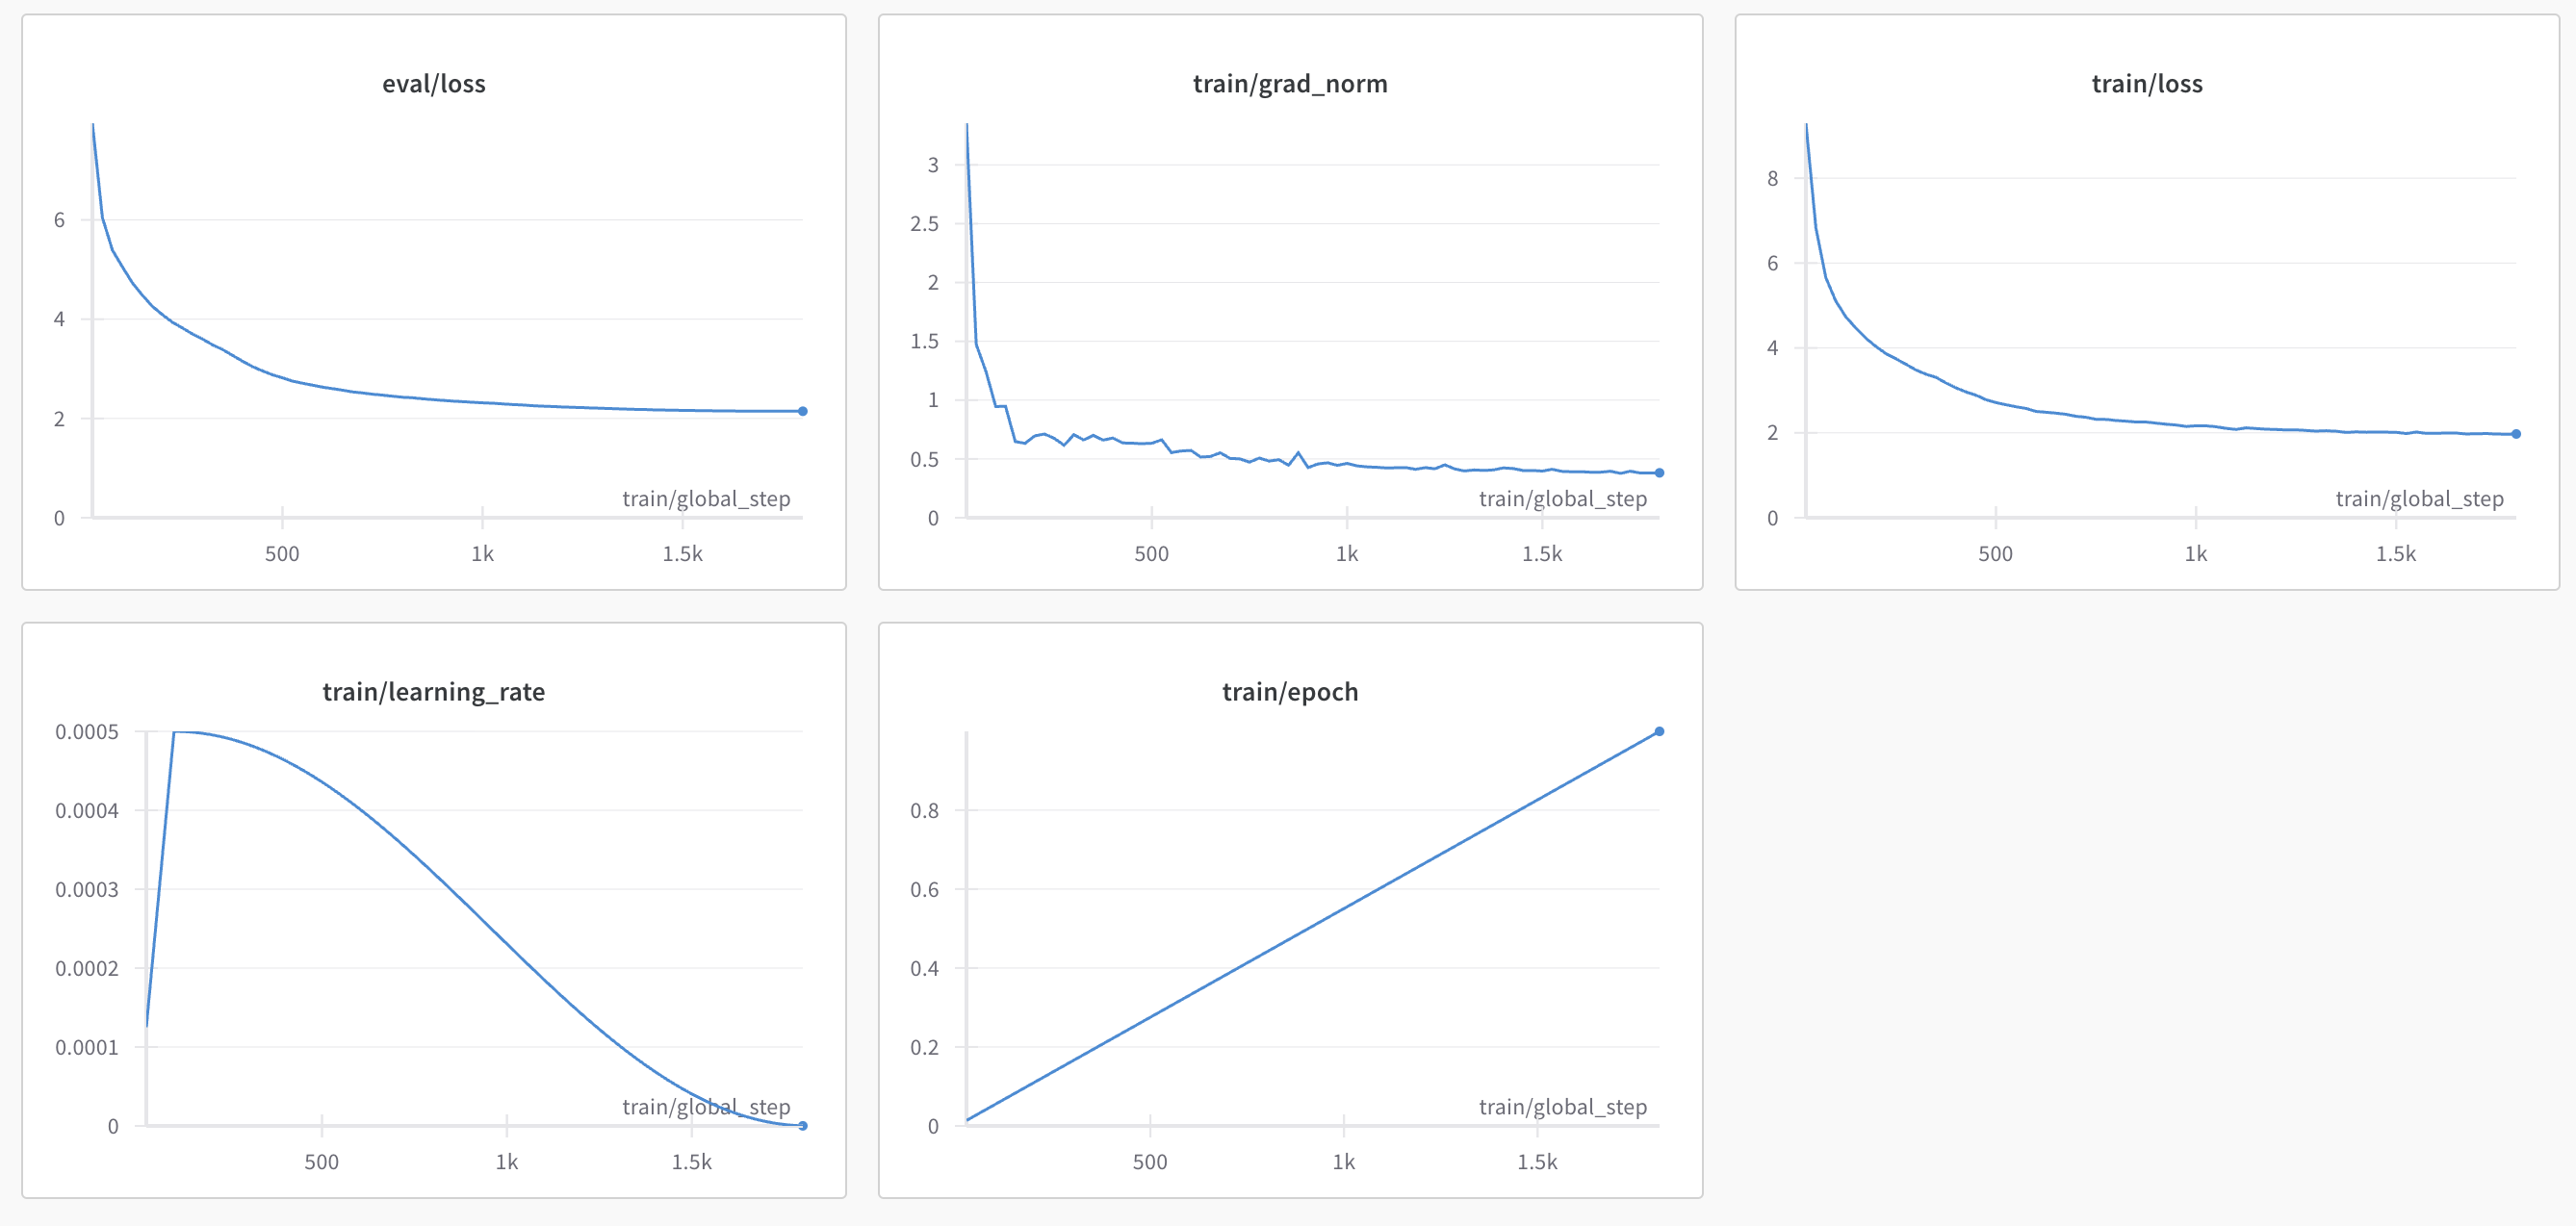

The training graphs suggest that our model might've gotten stuck in a local minima, since the gradient norms, validation loss, and training loss all plateaud. We could deal with this by trying different learning rates and LR schedulers. In the interest of time, I'm leaving that experiment for later.